In [9]:
!nvidia-smi --query-gpu=utilization.gpu --format=csv,noheader,nounits

Failed to initialize NVML: Driver/library version mismatch


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow import keras

import DataGenerator as DG
from DataGenerator import DataGenerator

from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

from keras_contrib.layers import crf
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy
#Progress bar fix: use callbacks=[Logger.JupyterProgbarLogger()] in fit method
#verbose=0 is also required
import JupyterProgbarLogger as Logger
from tqdm import tqdm_notebook as tqdm
from kerastuner.tuners import RandomSearch


import sklearn.metrics as metrics

import numpy as np
import random
import math

from datetime import datetime
import os
from shutil import copy
from functools import partial

import matplotlib.pyplot as plt

import h5py

###FIX NUMPY LOAD FOR DICTIONARIES
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

Using TensorFlow backend.


In [2]:
#Data Variables
BATCH_SIZE=8
DATA_AMOUNT=800000
VALIDATION_AMOUNT=10000
OFFSET_AMOUNT=0
VAL_OFFSET = 810000
#frames per sample / 3rd dimension for 3D CNN
depth=10
#Data file
filepath = "images_synthetic_mouse.h5"
#If you want to copy the file to a scratch directory
scratch_dir = ""#"/n/scratch2/ap487/"

USE_TUNER = False
USE_CRF = False

In [3]:
#Copy file to scratch directory if it is specified, and change filepath to match.
if not os.path.exists((scratch_dir+filepath)):
    copy(filepath,scratch_dir)
    print("File Copied to scratch directory")
filepath=scratch_dir+filepath
print("Using path: ",filepath)

Using path:  images_synthetic_mouse.h5


In [18]:
def create_sbatch(outdir = 'training',
                  job_name='train',
                  cores=16,
                  mem='48GB',
                  max_time='120:00:00',
                  num_gpus=1,
                  data_file = 'images_synthetic_mouse.h5',
                  data_amount = 0,
                  data_offset = 0,
                  validation_amount = 0,
                  validation_offset = 0,
                  batch_size = 8,
                  verbosity = 1,
                  epochs = 40,
                  dropout_chance = 0,
                  frames_per_sample = 10,
                  filters = 8
                 ):
    cmd = 'sbatch '
    cmd += '--job-name ' + job_name + ' '
    cmd += '--output "' + os.getcwd() + '/train-%j.log" '
    cmd += '--partition debug '
    cmd += '-n ' + str(cores) + ' '
    cmd += '--mem ' + mem + ' '
    cmd += '--time ' + max_time + ' '
    cmd += '--gres gpu:' + str(num_gpus) + ' '
    cmd += '--wrap="' + os.path.expanduser("~") + '/miniconda3/envs/tf2_gpu/bin/python train_model.py train '
    cmd += '--data-amount ' + str(data_amount) + ' '
    cmd += '--data-offset ' + str(data_offset) + ' '
    cmd += '--validation-amount ' + str(validation_amount) + ' '
    cmd += '--validation-offset ' + str(validation_offset) + ' '
    cmd += '--batch-size ' + str(batch_size) + ' '
    cmd += '--verbosity ' + str(verbosity) + ' '
    cmd += '--epochs ' + str(epochs) + ' '
    cmd += '--depth ' + str(frames_per_sample) + ' '
    cmd += '--dropout ' + str(dropout_chance) + ' '
    cmd += '--filters ' + str(filters) + ' '
    cmd += "'" + os.getcwd() + '/' + data_file +"' "
    cmd += "'" + os.getcwd() + '/' + outdir + '-%s/' +"' "
    cmd += '"'
    return cmd
print(create_sbatch(outdir='training',
              data_amount = 500000,
              data_offset = 100000,
              validation_amount=10000,
              validation_offset=1000000,
              dropout_chance=0.1,
              filters = 32,
              epochs=50,
              verbosity=0))

sbatch --job-name train --output "/home/g17amitprasad_gmail_com/2019-notebooks/Action Recognition/train-%j.log" --partition debug -n 16 --mem 48GB --time 120:00:00 --gres gpu:1 --wrap="/home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/bin/python train_model.py train --data-amount 500000 --data-offset 100000 --validation-amount 10000 --validation-offset 1000000 --batch-size 8 --verbosity 0 --epochs 50 --depth 10 --dropout 0.1 --filters 32 '/home/g17amitprasad_gmail_com/2019-notebooks/Action Recognition/images_synthetic_mouse.h5' '/home/g17amitprasad_gmail_com/2019-notebooks/Action Recognition/training-%s/' "


In [5]:
def build_model(tuner,
                input_shape=(80, 80, 1),
                stride_length=(1, 1),
                kernel=(3,3),
                kernel_initializer='glorot_uniform',
                activation=layers.Activation('relu'),
                dense_activation=layers.Activation('relu'),
                output_activation=layers.Activation('softmax'),
                batch_momentum=.999,
                dropout_chance=0.1,
                combine=True,
                padding='same',
                batch_norm=False,
                dropout=True
            ):
    name = "LSTM CNN"
    if depth > 1:
        input_shape = (depth,)+input_shape
    inputs = layers.Input(shape=input_shape)
    x = inputs
    conv_parameters = {
        'padding': padding,
        'strides': stride_length,
        'kernel_initializer': kernel_initializer
    }
    # encode net
    x = layers.TimeDistributed(layers.Conv2D(16, kernel, **conv_parameters),input_shape=input_shape)(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding=padding))(x)
    x = layers.TimeDistributed(layers.Conv2D(32, kernel, **conv_parameters))(x)
    x = layers.TimeDistributed(layers.Conv2D(32, kernel, **conv_parameters))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding=padding))(x)
    x = layers.TimeDistributed(layers.Conv2D(64, kernel, **conv_parameters))(x)
    x = layers.TimeDistributed(layers.Conv2D(64, kernel, **conv_parameters))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding=padding))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, kernel, **conv_parameters))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, kernel, **conv_parameters))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding=padding))(x)
    x = layers.TimeDistributed(layers.Flatten())(x)
    if dropout:
        x = layers.SpatialDropout1D(dropout_chance)(x)
    #x = layers.Bidirectional(layers.LSTM(512))(x)
    #x = layers.LSTM(512)(x)
    if USE_CRF:
        x = layers.LSTM(512,return_sequences=True)(x)
        output = crf.CRF(64)(x)
    else:
        x = layers.LSTM(512,return_sequences=False)(x)
        x = layers.Dense(64, activation='relu')(x)
        output = output_activation(x)
    model = keras.models.Model(inputs, output)
    model.compile(
        optimizer=keras.optimizers.SGD(
            learning_rate=1e-4,
            momentum=.9,
            nesterov=True,
            decay=1e-6
        ),
        loss='sparse_categorical_crossentropy',#crf_loss,
        metrics=['accuracy']
    )
    return model,name

In [6]:
if not depth == 1:
    if USE_TUNER:
        tuner = RandomSearch(
            build_model,
            objective='val_accuracy',
            max_trials=40,
            executions_per_trial=1,
            directory='actionrecog',
            project_name='Action Recognition',
            is_generator=True)
        print(tuner.search_space_summary())
    else:
        model,name = build_model(None,input_shape=(80,80,1))
        #model.summary()
else:
    model,name = build_model()
    model.summary()

In [7]:
#Initialize generators
data_gen = DataGenerator(filepath,data_amount=DATA_AMOUNT,batch_size=BATCH_SIZE,frames_per_sample=depth,offset=OFFSET_AMOUNT,sliding_window=5)
validation_gen = DataGenerator(filepath,data_amount=VALIDATION_AMOUNT,batch_size=BATCH_SIZE,frames_per_sample=depth,offset=VAL_OFFSET,sliding_window=5)

In [8]:
#model = keras.models.load_model('model-2019-08-01-01:13:21.h5')
if USE_TUNER:
    tuner.search(generator=data_gen, validation_data=validation_gen,
                use_multiprocessing=True, workers=10,
                epochs = 8)
    model = tuner.get_best_models(num_models=5)[0]
else:
    history = model.fit_generator(generator=data_gen,
                    validation_data=validation_gen,
                    epochs=100,
                    verbose=0,
                    use_multiprocessing=True,
                    workers=16,
                    callbacks=[Logger.JupyterProgbarLogger(count_mode='steps'),
                              keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6,verbose=1, mode='auto',restore_best_weights=True),
                              keras.callbacks.ModelCheckpoint(filepath='model_progress_{epoch:02d}.h5')]
                   )

W0802 13:11:24.265148 139662944175936 deprecation.py:323] From /home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Process Keras_worker_ForkPoolWorker-11:
Process Keras_worker_ForkPoolWorker-4:
Process Keras_worker_ForkPoolWorker-2:
Process Keras_worker_ForkPoolWorker-5:
Process Keras_worker_ForkPoolWorker-16:
Process Keras_worker_ForkPoolWorker-9:
Process Keras_worker_ForkPoolWorker-15:
Process Keras_worker_ForkPoolWorker-8:
Process Keras_worker_ForkPoolWorker-1:
Process Keras_worker_ForkPoolWorker-6:
Process Keras_worker_ForkPoolWorker-7:
Process Keras_worker_ForkPoolWorker-10:
Process Keras_worker_ForkPoolWorker-12:
Process Keras_worker_ForkPoolWorker-3:
Process Keras_worker_ForkPoolWorker-1

  File "/home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/home/g17amitprasad_gmail_com/2019-notebooks/Action Recognition/DataGenerator.py", line 116, in generate_chunk
    preload = f["/frames/raw"][start:end]
  File "/home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/multiprocessi

KeyboardInterrupt: 

In [ ]:
val_accs = np.zeros(len(range(2,33,2)))
val_accs[0]=0.5506
val_accs[1]=0.5441
test_num = 2
for d in range(6,33,2):
    depth = d
    model,name = build_model(None,input_shape=(80,80,1))
    data_gen = DataGenerator(filepath,data_amount=DATA_AMOUNT,batch_size=BATCH_SIZE,frames_per_sample=depth,offset=OFFSET_AMOUNT)
    validation_gen = DataGenerator(filepath,data_amount=VALIDATION_AMOUNT,batch_size=BATCH_SIZE,frames_per_sample=depth,offset=DATA_AMOUNT+OFFSET_AMOUNT)
    history = model.fit_generator(generator=data_gen,
                    validation_data=validation_gen,
                    epochs=5,
                    verbose=0,
                    use_multiprocessing=True,
                    workers=10,
                    callbacks=[Logger.JupyterProgbarLogger(count_mode='steps'),
                              keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6,verbose=1, mode='auto',restore_best_weights=True)]
                   )
    val_accs[test_num]=(history.history['val_accuracy'][::-1])[0]
    test_num+=1
    plt.plot(val_accs)
    plt.show()

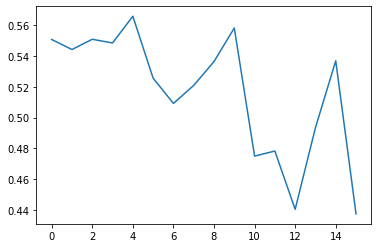

In [40]:
plt.plot(val_accs)
plt.show()

In [1]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

NameError: name 'plt' is not defined

In [8]:
filename = "model-"+datetime.today().strftime('%Y-%m-%d-%H:%M:%S')+".h5"
model.save(filename)
print("Model saved to ",filename)

Model saved to  model-2019-08-01-01:13:21.h5
